In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from scipy.stats import pearsonr, spearmanr
import h3pandas
import sys
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

tqdm.pandas()



In [15]:

def get_peaks(tmp):
    
    try:
        tmp = tmp.sort_values(by='DOY')
        val = tmp['delta_NDVI'].values
        peaks = find_peaks((val - np.nanmean(val))/np.nanstd(val), 
                           prominence=0.5, width=15)[0]
        if len(peaks)==0:
            return np.nan
        else:
            if val[peaks[0]]<0:
                return np.nan
            else:
                return tmp['DOY'].values[peaks[0]]
    except:
        return np.nan
    
def max_x(x):
    try:
        a = x['DOY'].values[np.argmax(x['delta_NDVI'].values)]
        return a
                            
    except:
        return np.nan


In [12]:
def calc_delta_NDVI(df):
    df['delta_NDVI'] = np.gradient(df['mean_NDVI'].values)
    return df

GW = []

for year in tqdm(range(2010,2021)):
    try:
        dat = pd.read_csv(f'../../data/D03.environmental_data/GreenWave_agg_h3_02_{year}.csv')
        dat['year'] = year
        dat = dat.groupby('h3_02').progress_apply(calc_delta_NDVI).reset_index(drop=True)
        GW.append(dat)

    except:
        continue
        
GW = pd.concat(GW, axis=0).reset_index(drop=True)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/2364 [00:00<?, ?it/s]

  0%|          | 0/2358 [00:00<?, ?it/s]

  0%|          | 0/2358 [00:00<?, ?it/s]

  0%|          | 0/2354 [00:00<?, ?it/s]

  0%|          | 0/2361 [00:00<?, ?it/s]

  0%|          | 0/2350 [00:00<?, ?it/s]

  0%|          | 0/2360 [00:00<?, ?it/s]

  0%|          | 0/2357 [00:00<?, ?it/s]

  0%|          | 0/2359 [00:00<?, ?it/s]

  0%|          | 0/2358 [00:00<?, ?it/s]

  0%|          | 0/2359 [00:00<?, ?it/s]

In [33]:
# spring_peak
spring_peak_date = GW[GW['DOY']<=183].groupby(['h3_02','year','lng','lat'], include_groups=False).apply(get_peaks)
spring_peak_date = pd.DataFrame(spring_peak_date, columns=['GW_peak_date']).reset_index(drop=False)
spring_peak_date.loc[spring_peak_date[(spring_peak_date['GW_peak_date']==1) | (spring_peak_date['GW_peak_date']==183)].index, 'GW_peak_date'] = None

# fall_peak
fall_tmp = GW[GW['DOY']>183]
fall_tmp['delta_NDVI'] = -fall_tmp['delta_NDVI']
fall_peak_date = fall_tmp.groupby(['h3_02','year','lng','lat'], include_groups=False).apply(get_peaks)
fall_peak_date = pd.DataFrame(fall_peak_date, columns=['GW_peak_date']).reset_index(drop=False)
fall_peak_date.loc[fall_peak_date[(fall_peak_date['GW_peak_date']==365) | (fall_peak_date['GW_peak_date']==366) | (fall_peak_date['GW_peak_date']==184)].index, 'GW_peak_date'] = None



/tmp/ipykernel_18743/3071453640.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  spring_peak_date = GW[GW['DOY']<=183].groupby(['h3_02','year','lng','lat']).apply(get_peaks)
/tmp/ipykernel_18743/3071453640.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fall_tmp['delta_NDVI'] = -fall_tmp['delta_NDVI']
/tmp/ipykernel_18743/3071453640.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in 

<Axes: xlabel='lat', ylabel='GW_peak_date'>

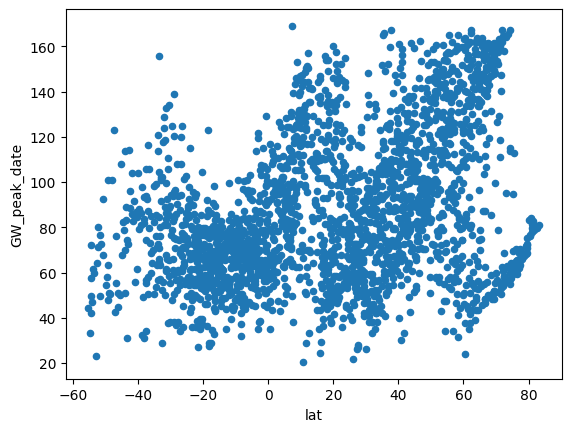

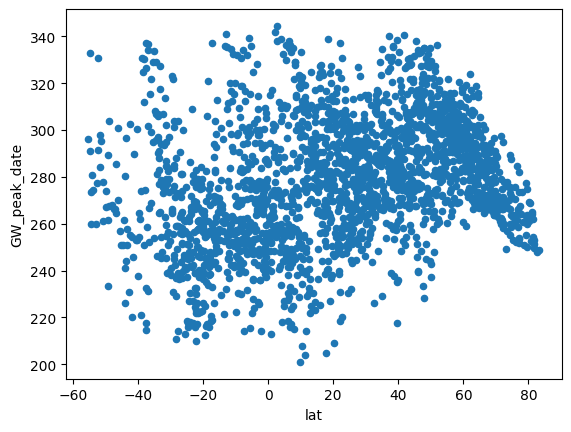

In [36]:
spring_peak_date.groupby('h3_02').mean().plot(x='lat', y='GW_peak_date', kind='scatter')
fall_peak_date.groupby('h3_02').mean().plot(x='lat', y='GW_peak_date', kind='scatter')


In [38]:
spring_peak_date['season'] = 'spring'
fall_peak_date['season'] = 'fall'
res = pd.concat([spring_peak_date, fall_peak_date], axis=0).reset_index(drop=False)
res.to_csv('../../data/D02.wave_peak/all_greenwave_peak.csv', index=False)


